In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

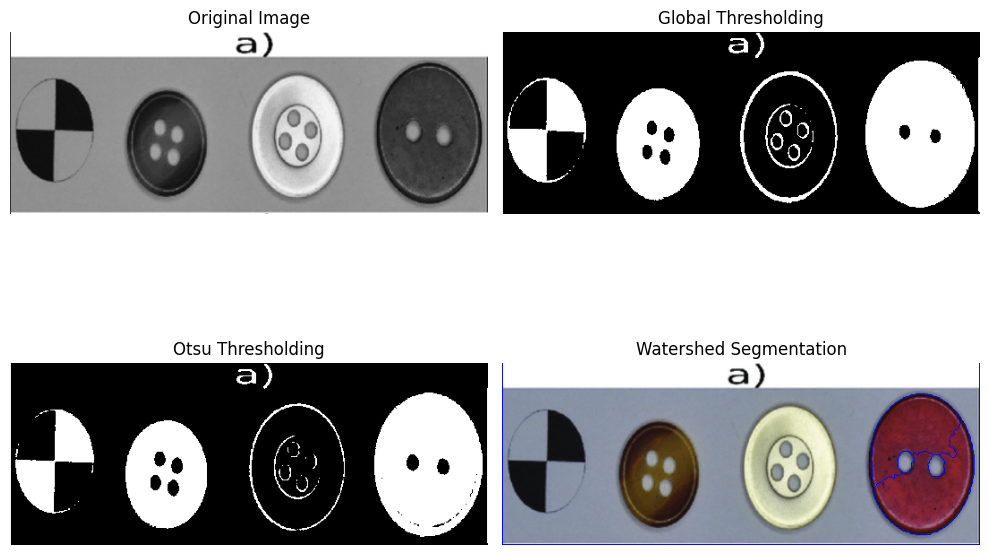

In [70]:
# Load an example image
img = cv2.imread('buttons.png', cv2.IMREAD_GRAYSCALE)

# Apply global thresholding
_, thresholded = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

# Apply Otsu's thresholding
_, otsu_thresholded = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Region-based segmentation using Watershed
# Convert to color for watershed processing
img_color = cv2.imread('buttons.png')

# Convert to grayscale and apply Otsu's threshold
gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise by applying morphological operations
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Background area (sure background)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Foreground area (sure foreground)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region (where we don't know if it’s background or foreground)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels to distinguish the background (which is 0)
markers = markers + 1

# Mark the unknown regions with zero
markers[unknown == 255] = 0

# Apply the Watershed algorithm
markers = cv2.watershed(img_color, markers)
img_color[markers == -1] = [255, 0, 0]  # Mark boundary with red

# Plot the results for comparison
titles = ['Original Image', 'Global Thresholding', 'Otsu Thresholding', 'Watershed Segmentation']
images = [img, thresholded, otsu_thresholded, img_color]

plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    if i == 3:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # For color image
    else:
        plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

    
# Show the images
plt.tight_layout()
plt.show()

In [71]:

binary_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV, 3, 2 )

cv2.imshow("Adaptive Thresholding", binary_img)
cv2.imshow("Otsu Thresholding", otsu_thresholded)
cv2.waitKey(0) 
cv2.destroyAllWindows()


In [42]:
img = cv2.imread('buttons.png')
assert img is not None, "file could not be read, check with os.path.exists()"
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)



In [58]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
 
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=5)
 
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
 
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [53]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
 
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
 
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [54]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [59]:
#cv2.imshow("markers", markers)
cv2.imshow("image", img)
cv2.waitKey(0) 
cv2.destroyAllWindows()

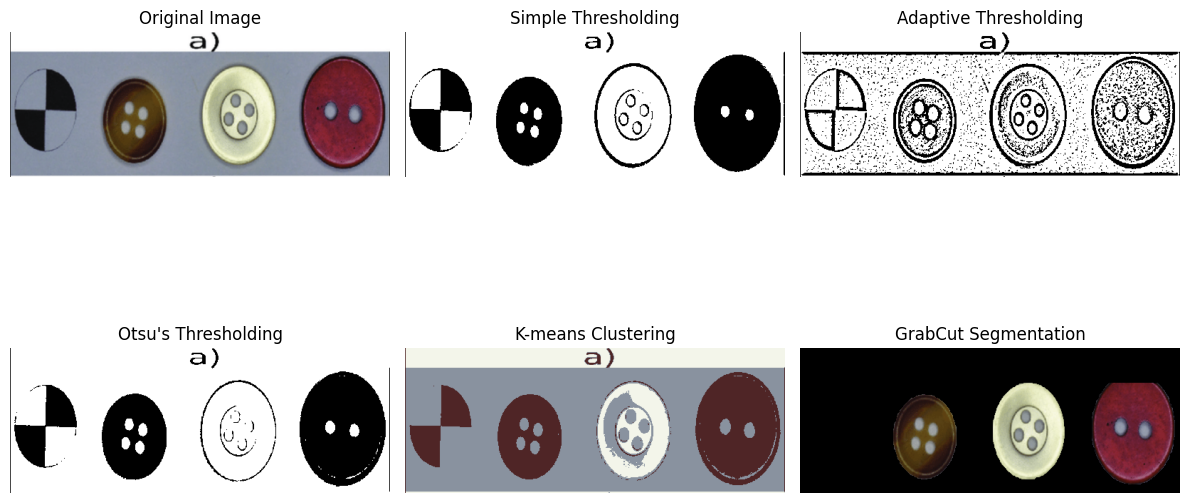

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('buttons.png')

# Convert the image to grayscale for thresholding
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ============ 1. THRESHOLDING-BASED SEGMENTATION ============

# 1.1 Simple Thresholding
_, simple_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 1.2 Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)

# 1.3 Otsu's Thresholding
_, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ============ 2. K-MEANS CLUSTERING-BASED SEGMENTATION ============

# Convert the image into a 2D array of pixels
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define stopping criteria and the number of clusters (K)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3  # Number of clusters

# Apply k-means clustering
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to 8-bit values and reshape to the original image
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img.shape)

# ============ 3. GRABCUT SEGMENTATION ============

# Initialize mask
mask = np.zeros(img.shape[:2], np.uint8)

# Specify the rectangle around the object
rect = (50, 50, img.shape[1] - 50, img.shape[0] - 50)

# Create temporary arrays for grabCut algorithm
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Apply grabCut algorithm
cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

# Modify the mask so that all 0 and 2 pixels are set to background, 1 and 3 to foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Apply the mask to the image
grabcut_result = img * mask2[:, :, np.newaxis]

# ============ Plotting the Results ============

titles = ['Original Image', 'Simple Thresholding', 'Adaptive Thresholding', 
          'Otsu\'s Thresholding', 'K-means Clustering', 'GrabCut Segmentation']
images = [img, simple_thresh, adaptive_thresh, otsu_thresh, segmented_image, grabcut_result]

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    if i == 0 or i == 4 or i == 5:  # For original and color-segmented images
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    else:  # For thresholded images
        plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

# Display the images
plt.tight_layout()
plt.show()


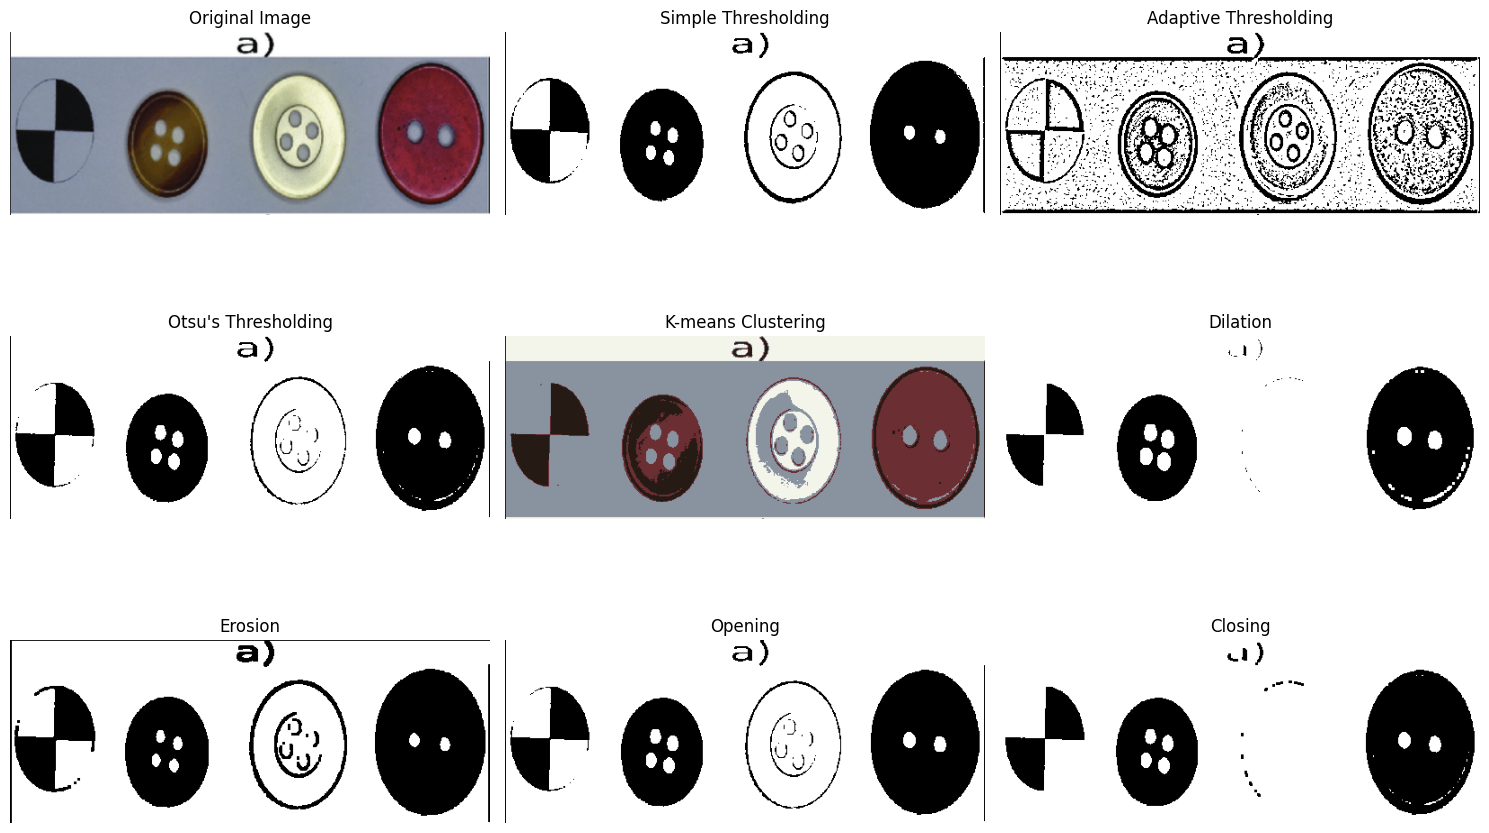

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('buttons.png')

# Convert the image to grayscale for thresholding
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ============ 1. THRESHOLDING-BASED SEGMENTATION ============

# 1.1 Simple Thresholding
_, simple_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 1.2 Adaptive Thresholding (better for uneven lighting)
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)

# 1.3 Otsu's Thresholding
_, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ============ 2. K-MEANS CLUSTERING-BASED SEGMENTATION ============

# Convert the image into a 2D array of pixels
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define stopping criteria and the number of clusters (K)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4  # We choose 4 clusters for each button

# Apply k-means clustering
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to 8-bit values and reshape to the original image
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img.shape)

# ============ 3. MORPHOLOGICAL OPERATIONS (for refining segmentation) ============

# Define a kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Dilation (expand bright regions)
dilated = cv2.dilate(otsu_thresh, kernel, iterations=1)

# Erosion (reduce noise)
eroded = cv2.erode(otsu_thresh, kernel, iterations=1)

# Opening (erosion followed by dilation to remove noise)
opening = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel)

# Closing (dilation followed by erosion to close gaps)
closing = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel)

# ============ Plotting the Results ============

titles = ['Original Image', 'Simple Thresholding', 'Adaptive Thresholding', 
          'Otsu\'s Thresholding', 'K-means Clustering', 'Dilation', 'Erosion', 'Opening', 'Closing']
images = [img, simple_thresh, adaptive_thresh, otsu_thresh, segmented_image, dilated, eroded, opening, closing]

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    if i == 0 or i == 4:  # For original and color-segmented images
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    else:  # For thresholded and morphological images
        plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

# Display the images
plt.tight_layout()
plt.show()


In [72]:
cv2.imshow("K-means", segmented_image)
cv2.waitKey(0) 
cv2.destroyAllWindows()

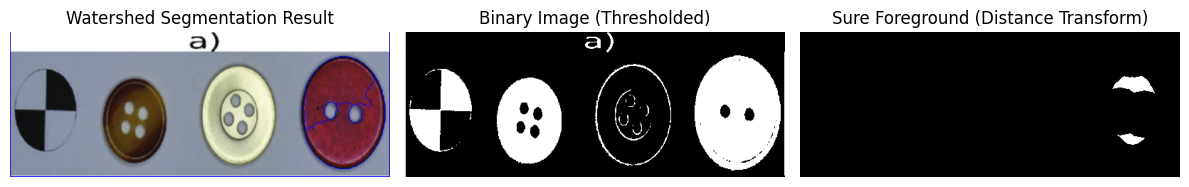

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('buttons.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Otsu's Thresholding to get binary image
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small noise using morphological opening
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Dilate the image to get sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Use distance transform to get sure foreground regions
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Convert sure foreground to uint8 and subtract it from the background
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Label the markers
_, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so that the sure background is not 0
markers = markers + 1

# Mark the unknown region (boundaries) with 0
markers[unknown == 255] = 0

# Apply the watershed algorithm
markers = cv2.watershed(img, markers)

# Mark the boundaries with red color
img[markers == -1] = [255, 0, 0]

# ============ Plotting the Results ============

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation Result')
plt.axis('off')

# Thresholded Image
plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image (Thresholded)')
plt.axis('off')

# Sure Foreground
plt.subplot(1, 3, 3)
plt.imshow(sure_fg, cmap='gray')
plt.title('Sure Foreground (Distance Transform)')
plt.axis('off')

# Show the result
plt.tight_layout()
plt.show()
